In [9]:
using LinearAlgebra
using Distributions
using Random
using SparseArrays
using JLD2

include("../../Inversion/Plot.jl")
include("../../Inversion/KalmanInversion.jl")
include("../../Fluid/Spectral-Navier-Stokes.jl")
include("../../Fluid/Spectral-Mesh.jl")

Visual_Obs (generic function with 1 method)

# Navier-Stokes Problem

We consider the 2D Navier-Stokes equation on a periodic domain $D = [0,2\pi]\times[0,2\pi]$:

$$
\begin{equation*}
\begin{split}
    &\frac{\partial v}{\partial t} + (v\cdot \nabla) v + \nabla p - \nu\Delta v = f, \\
    &\nabla \cdot v = 0, \\
    &\frac{1}{4\pi^2}\int v  = v_b;
    \end{split}
\end{equation*}
$$

here $v$ and $p$ denote the velocity vector and the pressure, $\nu$ denotes the dynamic viscosity, $v_b$ denotes the non-zero mean background velocity, and $f$ denotes a zero-mean periodic forcing term (Hence, the mean background velocity will not change).


The forward problem can be rewritten in the vorticity-streamfunction ($\omega-\psi$) formulation:

$$
\begin{equation*}
\begin{split}
    &\frac{\partial \omega}{\partial t} + (v\cdot\nabla)\omega - \nu\Delta\omega = \nabla \times f, \\
    &\omega = \nabla \times v,\\
\end{split}
\end{equation*}
$$

with periodic initial condition $\omega = \omega_0$. The velocity is recovered from the vorticity through the streamfunction 

$$
\begin{equation*}
\begin{split}
    &\omega = -\Delta\psi \qquad \frac{1}{4\pi^2}\int\psi = 0,\\
    &v = \Big(\frac{\partial \psi}{\partial y}, -\frac{\partial \psi}{\partial x}\Big) + v_b,
\end{split}
\end{equation*}
$$

The Pressure can be computed from 

$$\Delta p = \nabla \cdot f + 2\Big(\frac{\partial u}{\partial x}\frac{\partial v}{\partial y} - \frac{\partial u}{\partial y}\frac{\partial v}{\partial x}\Big)$$

## Pseudo-Spectral Method

The solution $\omega$  is expanded in the fourier basis functions:
$$
\omega = \sum_{k_x\in{Z}, k_y\in{Z}}  \hat{\omega}_{k_x,k_y}(t)  e^{i (2\pi k_x\frac{x}{L_x} + 2\pi k_y\frac{y}{L_y})}
$$
here $L_x = L_y = 2\pi$ are the periodic domain sizes.


Assume the domain is discretized by $N_x+1$ and $N_y+1$ uniform grids in each direction with grid points

$$
\begin{align*}
&0 = x_0 < x_1 <\cdots < x_{N_x} = L_x \qquad 0 = y_0 < y_1 <\cdots < y_{N_y} = L_y
\end{align*}
$$

For the convinence of applying Discrete Fourier Transform, we rewrite the solution of $\omega$ as following 

$$
\omega = \frac{1}{N_xN_y}\sum_{k_x=-N_x/2}^{N_x/2-1}\sum_{k_y=-N_y/2}^{N_y/2-1} \hat{\omega}_{k_x,k_y}(t)  e^{i (2\pi k_x\frac{x}{L_x} + 2\pi k_y\frac{y}{L_y})}
$$

here we assume both $N_x$ and $N_y$ are even numbers.


By applying fourier transformation to the vorticity-streamfunction formulation, we have

$$
\frac{d \hat{\omega}_{k_x,k_y}}{d t} + \widehat{\Big((v\cdot\nabla)\omega\Big)}_{k_x,k_y} + 
\nu\Big(\frac{(2\pi k_x)^2}{L_x^2} + \frac{(2\pi k_y)^2}{L_y^2}\Big) \hat{\omega}_{k_x,k_y} = \widehat{\Big(\nabla \times f\Big)}_{k_x,k_y}
$$





## Advection Term and Dealiasing

To compute the advection term $(v\cdot\nabla)\omega$, we will first compute the velcity.
Luckily, solving Laplacian equation and computing gradients are almost free for pseudo-spectral methods. 

We have 

$$
\hat{\psi}_{k_x, k_y} 
= \sum_{k_x, k_y} \frac{\hat{\omega}_{k_x,k_y}}{\frac{(2\pi k_x)^2}{L_x^2} + \frac{(2\pi k_y)^2}{L_y^2}}
$$

It is worth mentioning, the $\hat{\psi}_{0, 0}$ is not well-defined, but the zero-mean condition leads to 
$\hat{\psi}_{0, 0} = 0$, and it does not affect the velocity.

The velocity can be recovered as

$$\hat{v}_{k_x, k_y} = \Big(i\frac{2\pi k_y}{L_y}\hat{\psi}_{k_x, k_y},\, -i\frac{2\pi k_x}{L_x}\hat{\psi}_{k_x, k_y}\Big)\qquad \hat{v}_{0, 0} =  v_b N_x N_y $$

Then we compute the gradient of the vorticity, 

$$\widehat{\Big(\nabla \omega\Big)}_{k_x, k_y} = \Big(i\frac{2\pi k_x}{L_x}\hat{\omega}_{k_x, k_y},\, i\frac{2\pi k_y}{L_y}\hat{\omega}_{k_x, k_y}\Big)$$

We can apply Inverse Fourier Transform to obtain $v$ and $\omega$, conduct the production, and transform back to obtain the advection term in the spectral space. 

However, we need to be cautious about the aliasing error, when we conduct the production or any nonlinear operators.


### Aliasing Error
Consider 1D Fourier functions
$$
\begin{align*}
a = \frac{1}{N_x}\sum_{k_x}\hat{a}_{k_x}  e^{i (2\pi k_x\frac{x}{L_x})}\\
b = \frac{1}{N_x}\sum_{k_x}\hat{b}_{k_x}  e^{i (2\pi k_x\frac{x}{L_x})}
\end{align*}
$$

Their Fourier expansion of their product is 
$$
\begin{align*}
ab = \frac{1}{N_x^2}\sum_{k_x} \sum_{k'_{x}}
\hat{a}_{k_x}\hat{b}_{k'_{x}}  e^{i 2\pi (k_x + k'_x)\frac{x}{L_x}}
\quad \textrm{ with } \quad
\widehat{\Big(ab\Big)}_{m} = \frac{1}{N_x}\sum_{k_x + k'_{x} = m} 
\hat{a}_{k_x}\hat{b}_{k'_{x}}
\end{align*}
$$

However, at the discrete level, we have
$$
\begin{align*}
a(x_j) b(x_j) &= \frac{1}{N_x^2}\sum_{k_x} \sum_{k'_{x}}
\hat{a}_{k_x}\hat{b}_{k'_{x}}  e^{i 2\pi (k_x + k'_x)\frac{x_j}{L_x}} \\
&= \frac{1}{N_x^2}\sum_{k_x} \sum_{k'_{x}}
\hat{a}_{k_x}\hat{b}_{k'_{x}}  e^{i 2\pi (k_x + k'_x)\frac{j}{N_x}} \\
&= \frac{1}{N_x}\sum_{m} \sum_{\textrm{mod}(k_x + k'_{x},\, N_x) = m}
\frac{\hat{a}_{k_x}\hat{b}_{k'_{x}}}{N_x}  e^{i 2\pi m\frac{j}{N_x}} \\
\end{align*}.
$$
For the mode $m$, if we have $k_x + k'_{x} =  k N_x + m$ for any nonzero $k$ aliasing error appears, since the product $\frac{\hat{a}_{k_x}\hat{b}_{k'_{x}}}{N_x}$ is not suppose to contribute the $m$ mode. The aliasing error can accumulate and leads to numerical instability. 

Therefore, the Orszag 2/3-Rule[1] is required for pseudo-spectral methods. It states that we should keep at most 2/3 of the Fourier modes 
$$
\begin{align*}
a = \frac{1}{N_x}\sum_{k_x = -K}^{K}\hat{a}_{k_x}  e^{i (2\pi k_x\frac{x}{L_x})} \qquad K < \frac{N_x}{3}\\
\end{align*}
$$
With this truncation, the aliasing error will not happen. Since when $|k_x|, |k'_{x}|, |m| < \frac{N_x}{3}$, we have 

$$k_x + k'_{x} \neq  k N_x + m \qquad (k \neq 0)$$


For the convenience of applying Discrete Fourier Transform, we pad zeros for these modes $k_x (|k_x| \geq \frac{N_x}{3})$, and set these modes to 0 after each Discrete Fourier Transform.

1. S.A. Orszag and G.S. Patterson Jr. "Numerical simulation of three-dimensional homogeneousisotropic turbulence".

## Crank-Nicolson Semi-Implicit Time-Integrator

Any time integration methods can be applied to solve the semi-discretized vorticity-streamfunction equation. 

Here we introduce the Crank-Nicolson semi-implicit time-integrator, which treats the diffusive term implicitly. Therefore, the scheme is able to achieve better stability compared with explicit schemes with minimum additional cost.

Let $A \hat{\omega}$ denote the linear diffusive term, and $r^{exp}$ denote other terms, the semi-discretized vorticity-streamfunction equation can be rewritten as 

$$\frac{d \hat{\omega}}{dt} = A \hat{\omega} + r^{exp}(\hat{\omega})$$

We have
$$
\begin{align*}
\frac{\hat{\omega}^{n+1} - \hat{\omega}^{n}} {\Delta t} 
= \frac{A \hat{\omega}^{n+1} + A \hat{\omega}^{n}}{2} + r^{exp}(\hat{\omega}^{n}) \\
(I - \frac{A\Delta t}{2})\frac{\hat{\omega}^{n+1} - \hat{\omega}^{n}} {\Delta t} 
= A \hat{\omega}^{n} + r^{exp}(\hat{\omega}^{n})\\
\delta \hat{\omega}^{n} = (I - \frac{A\Delta t}{2})^{-1}\Big(A \hat{\omega}^{n} + r^{exp}(\hat{\omega}^{n})\Big)
\end{align*}
$$
Compared with forward Euler scheme, the residual is shrinked, since the diffusivity is positive (A < 0).


## Kolmogorov Forcing 
The flow is driven by the deterministic Kolmogorov forcing 

$$ f = \Big(\sin(k_f y) ,\, 0\Big)^T $$ 

where $k_f = 4$ is the forcing wavenumber. In spite of the simplicity of the forcing and the boundary conditions, the Kolmogorov flow exhibits complex chaotic dynamics
when the Reynolds number $Re = \nu^{-1}$ is sufficiently large.


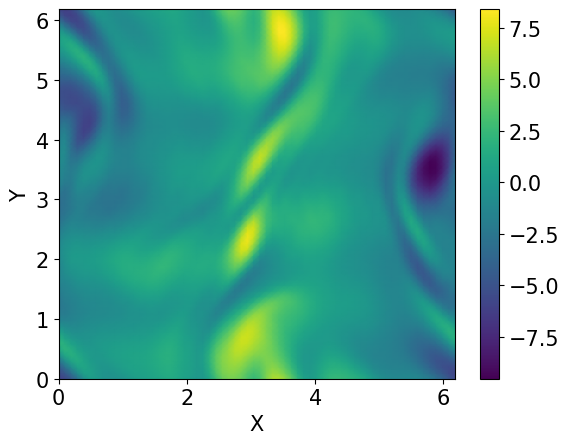

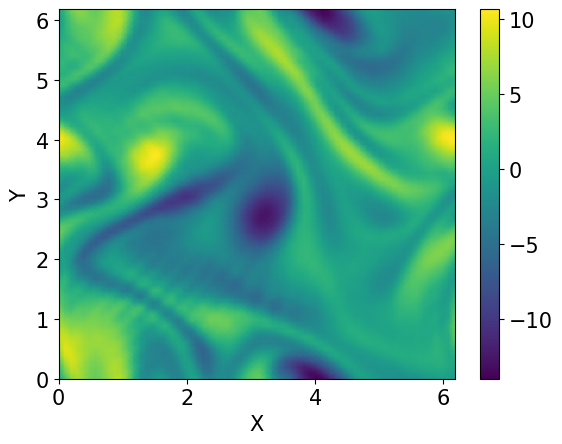

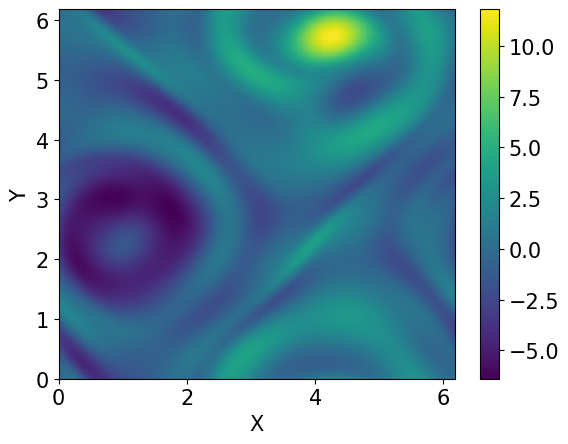

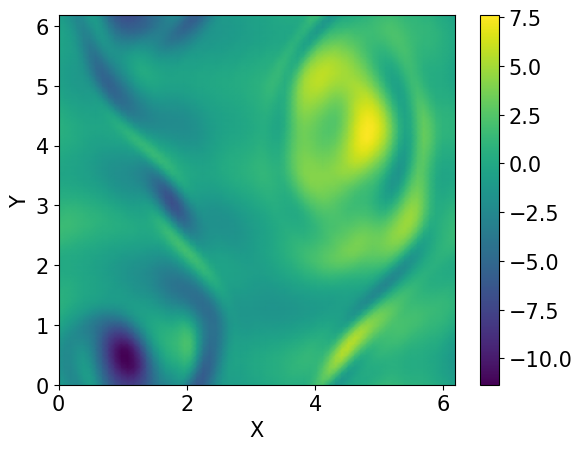

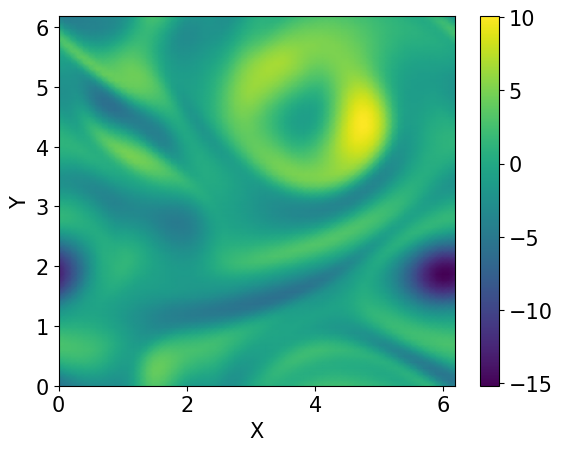

In [7]:
ν = 1.0e-2                                      # viscosity
N, L = 64, 2*pi                                 # resolution and domain size 
ub, vb = 0.0, 0.0                               # background velocity 
method="Crank-Nicolson"                         # RK4 or Crank-Nicolson
N_t = 50000;                                     # time step
T = 100.0;                                        # final time
obs_ΔNx, obs_ΔNy, obs_ΔNt = 16, 16, 5000        #observation
σ = sqrt(2)*pi
N_KL = 0
N_θ = 100
symmetric = false
# this is used for generating random initial condition
s_param = Setup_Param(ν, ub, vb,  
    N, L,  
    method, N_t,
    obs_ΔNx, obs_ΔNy, obs_ΔNt, symmetric,
    N_KL,
    N_θ;
    f = (x, y) -> (sin(4*y), 0),
    σ = σ)

ω0_ref = s_param.ω0_ref
mesh = Spectral_Mesh(N, N, L, L)
solver = Spectral_NS_Solver(mesh, ν; fx = s_param.fx, fy = s_param.fy, ω0 = ω0_ref, ub = ub, vb = vb)  



Δt = T/N_t 
for i = 1:N_t
    Solve!(solver, Δt, method)
    
    if i%10000 == 0
        Update_Grid_Vars!(solver)
        PyPlot.figure(figsize = (4,3))
        Visual(mesh, solver.ω, "ω")
    end
end



# Inverse Problem : Optimization Approach


We study the problem of recovering the initial vorticity field from measurements
at positive times. We parameterize it as $\omega_0(x, \theta)$, defined by parameters $\theta \in \mathcal{R}^{N_{\theta}}$, and modeled as a Gaussian field with covariance operator $\mathsf{C} = \Delta^{-2}$, subject to periodic boundary conditions, on the space of spatial-mean zero functions. The KL expansion of the initial vorticity field is given by 

$$\begin{equation}
\omega_0(x, \theta) = \sum_{l\in K} \theta^{c}_{(l)} \sqrt{\lambda_{l}} \psi^c_l  +  \theta^{s}_{(l)}\sqrt{\lambda_{l}} \psi^s_l,
\end{equation}$$

where $K = \{(k_x, k_y)| k_x + k_y > 0 \textrm{ or } (k_x + k_y = 0 \textrm{ and } k_x > 0)\}$, and the eigenpairs are of the form

$$\begin{equation}
    \psi^c_l(x) =\frac{\cos(l\cdot x)}{\sqrt{2}\pi}\quad \psi^s_l(x) =\frac{\sin(l\cdot x)}{\sqrt{2}\pi} \quad \lambda_l = \frac{1}{|l|^{4}},
\end{equation}$$

and $\theta^{c}_{(l)},\theta^{s}_{(l)}  \sim \mathcal{N}(0,2\pi^2)$ i.i.d. The KL expansion can be rewritten as a sum over $\mathcal{Z}^{0+}$ rather than a lattice: 

$$\begin{equation}
    \omega_0(x,\theta) = \sum_{k\in \mathcal{Z}^{0+}} \theta_{(k)}\sqrt{\lambda_k} \psi_k(x),
\end{equation}$$

where the eigenvalues $\lambda_k$ are in descending order. 


For the inverse problem, we assume the background mean velocity $v_b = (2\pi,\,2\pi)$ is known and there is no forcing term $(f = 0)$.  We recover the initial condition, specifically the initial vorticity field of the Navier-Stokes equation, given pointwise observations $y_{ref}$ of the vorticity field at 16 equidistant points($N_y=32$) at $T=0.25$ and $T=0.5$.
The observations $y_{obs}$ are defined by adding $5\%$ Gaussian random noises as following

$$
\begin{equation}
    y_{obs} = y_{ref} + \epsilon \odot  \mathcal{N}(0, I),
\end{equation}
$$

The initial vorticity field $\omega_{0,ref}$ is generated with all $85^2$ Fourier modes, and the first $N_{\theta}=100$ KL modes are recovered. And, hence this is a mis-specified model. 


┌ Info: ("N_y = ", 48)
└ @ Main /central/home/dzhuang/Code/InverseProblems.jl/Fluid/Spectral-Navier-Stokes.jl:325
┌ Info: ("y - y_mirror = ", 4.711912605184444e-15)
└ @ Main In[17]:27


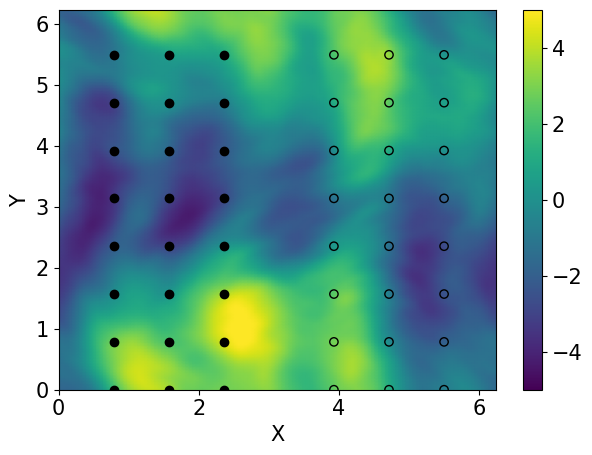

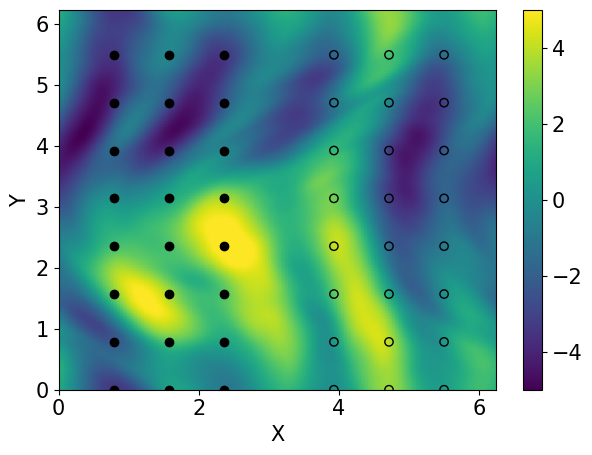

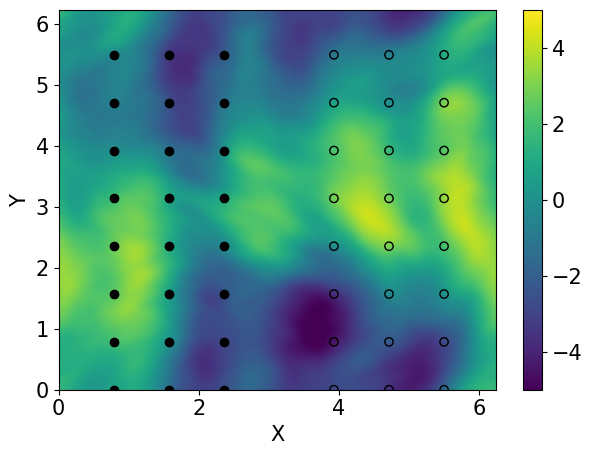

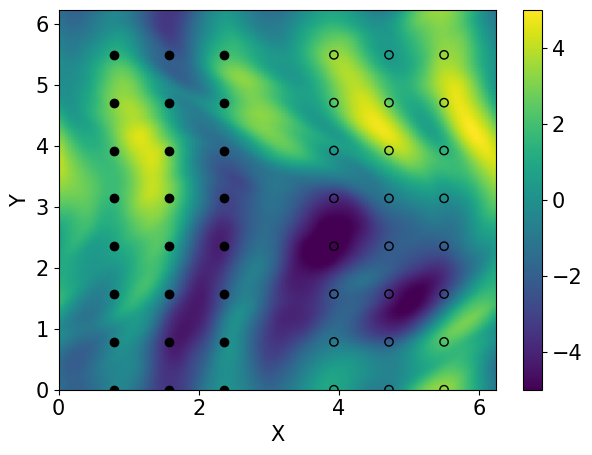

In [17]:
ν = 1.0e-2                                      # viscosity
N, L = 128, 2*pi                                 # resolution and domain size 
ub, vb = 0.0, 2*pi                        # background velocity 
method="Crank-Nicolson"                         # RK4 or Crank-Nicolson
N_t = 2500;                                     # time step
T = 0.5;                                        # final time
obs_ΔNx, obs_ΔNy, obs_ΔNt = 16, 16, 1250         # observation
symmetric = true
σ_0 = sqrt(2)*pi
N_KL = 0
N_θ = 64

mesh = Spectral_Mesh(N, N, L, L)
s_param = Setup_Param(ν, ub, vb,  
    N, L,  
    method, N_t,
    obs_ΔNx, obs_ΔNy, obs_ΔNt, symmetric,
    N_KL,
    N_θ;
    f = (x, y) -> (0, cos(4*x)),
    σ = σ_0)
ω0_ref = s_param.ω0_ref
ω0_ref_mirror = -ω0_ref[[1;end:-1:2], :]
# generate observation data
y_noiseless = forward_helper(s_param, ω0_ref; symmetric=true, save_file_name="NS", vmin=-5.0, vmax=5.0);
y_noiseless_mirror = forward_helper(s_param, ω0_ref_mirror; symmetric=true, save_file_name="NS_mirror", vmin=-5.0, vmax=5.0);
@info "y - y_mirror = ", norm(y_noiseless - y_noiseless_mirror)

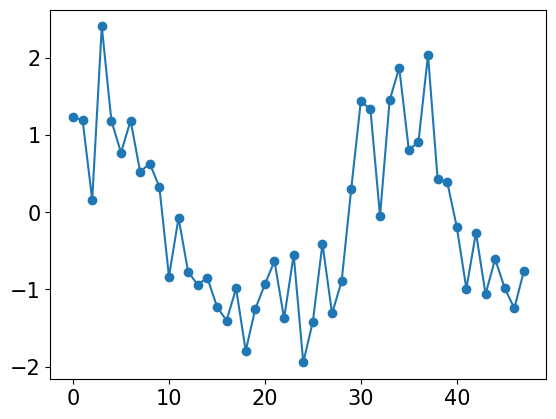

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f227b51e8d0>

In [18]:
plot(y_noiseless, "-o")

## Gaussian Mixture Kalman Inversion

The GMKI is initialized with $\theta_0 \sim \mathcal{N}(0, 10I)$ and the observation 
error assumed for inversion purposes is $\eta \sim \mathcal{N}(0, I)$. And this problem 
is insensitive to the observation error, and the results obtained with $\alpha = 1$ (no regularization) 
are presented.




In [22]:
# compute posterior distribution by UKI
N_iter =10
update_freq = 1
N_modes = 3
θ0_w  = fill(1.0, N_modes)/N_modes



θ0_mean, θθ0_cov  = zeros(N_modes, N_θ), zeros(N_modes, N_θ, N_θ)
Random.seed!(63);
for i = 1:N_modes
    θ0_mean[i, :]    .= rand(Normal(0, σ_0), N_θ) 
    θθ0_cov[i, :, :] .= Array(Diagonal(fill(1.0^2, N_θ)))
end
μ_0 = zeros(Float64, N_θ)  # prior/initial mean 
Σ_0 = Array(Diagonal(fill(σ_0^2, N_θ)))  # prior/initial covariance


σ_η = 0.05
N_y = length(y_noiseless)
Random.seed!(123);
y = y_noiseless + rand(Normal(0, σ_η), N_y)
Σ_η = Array(Diagonal(fill(σ_η^2, N_y)))


### Augment the system
aug_y = [y; μ_0]
aug_Σ_η = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y) Σ_0]  
s_param.N_y = length(aug_y)


γ = 1.0
Δt = γ/(1+γ)
@time ukiobj = GMUKI_Run(s_param, aug_forward, θ0_w, θ0_mean, θθ0_cov, aug_y, aug_Σ_η, γ, update_freq, N_iter; unscented_transform="modified-2n+1")
@save "ukiobj.jld2" ukiobj



┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /central/home/dzhuang/Code/InverseProblems.jl/Inversion/GMKI.jl:77


LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:
    Stacktrace:
      [1] [0m[1mArray[22m
    [90m    @ [39m[90m./[39m[90m[4mboot.jl:459[24m[39m[90m [inlined][39m
      [2] [0m[1mArray[22m
    [90m    @ [39m[90m./[39m[90m[4mboot.jl:467[24m[39m[90m [inlined][39m
      [3] [0m[1mArray[22m
    [90m    @ [39m[90m./[39m[90m[4mboot.jl:474[24m[39m[90m [inlined][39m
      [4] [0m[1msimilar[22m
    [90m    @ [39m[90m./[39m[90m[4mabstractarray.jl:829[24m[39m[90m [inlined][39m
      [5] [0m[1msimilar[22m
    [90m    @ [39m[90m./[39m[90m[4mabstractarray.jl:828[24m[39m[90m [inlined][39m
      [6] [0m[1msimilar[22m
    [90m    @ [39m[90m./[39m[90m[4mbroadcast.jl:212[24m[39m[90m [inlined][39m
      [7] [0m[1msimilar[22m
    [90m    @ [39m[90m./[39m[90m[4mbroadcast.jl:211[24m[39m[90m [inlined][39m
      [8] [0m[1mcopy[22m
    [90m    @ [39m[90m./[39m[90m[4mbroadcast.jl:885[24m[39m[90m [inlined][39m
      [9] [0m[1mmaterialize[22m
    [90m    @ [39m[90m./[39m[90m[4mbroadcast.jl:860[24m[39m[90m [inlined][39m
     [10] [0m[1mbroadcast_preserving_zero_d[22m
    [90m    @ [39m[90m./[39m[90m[4mbroadcast.jl:849[24m[39m[90m [inlined][39m
     [11] [0m[1mreal[22m[0m[1m([22m[90mA[39m::[0mMatrix[90m{ComplexF64}[39m[0m[1m)[22m
    [90m    @ [39m[90mBase[39m [90m./[39m[90m[4marraymath.jl:30[24m[39m
     [12] [0m[1mTrans_Spectral_To_Grid![22m[0m[1m([22m[90mmesh[39m::[0mSpectral_Mesh, [90mu_hat[39m::[0mMatrix[90m{ComplexF64}[39m, [90mu[39m::[0mMatrix[90m{Float64}[39m[0m[1m)[22m
    [90m    @ [39m[35mMain[39m [90m/central/home/dzhuang/Code/InverseProblems.jl/Fluid/[39m[90m[4mSpectral-Mesh.jl:133[24m[39m
     [13] [0m[1mCompute_Horizontal_Advection![22m[0m[1m([22m[90mmesh[39m::[0mSpectral_Mesh, [90mω_hat[39m::[0mMatrix[90m{ComplexF64}[39m, [90mδω_hat[39m::[0mMatrix[90m{ComplexF64}[39m, [90mub[39m::[0mFloat64, [90mvb[39m::[0mFloat64[0m[1m)[22m
    [90m    @ [39m[35mMain[39m [90m/central/home/dzhuang/Code/InverseProblems.jl/Fluid/[39m[90m[4mSpectral-Mesh.jl:340[24m[39m
     [14] [0m[1mSemi_Implicit_Residual![22m[0m[1m([22m[90mself[39m::[0mSpectral_NS_Solver, [90mω_hat[39m::[0mMatrix[90m{ComplexF64}[39m, [90mΔt[39m::[0mFloat64, [90mδω_hat[39m::[0mMatrix[90m{ComplexF64}[39m[0m[1m)[22m
    [90m    @ [39m[35mMain[39m [90m/central/home/dzhuang/Code/InverseProblems.jl/Fluid/[39m[90m[4mSpectral-Navier-Stokes.jl:172[24m[39m
     [15] [0m[1mSolve![22m[0m[1m([22m[90mself[39m::[0mSpectral_NS_Solver, [90mΔt[39m::[0mFloat64, [90mmethod[39m::[0mString[0m[1m)[22m
    [90m    @ [39m[35mMain[39m [90m/central/home/dzhuang/Code/InverseProblems.jl/Fluid/[39m[90m[4mSpectral-Navier-Stokes.jl:247[24m[39m
     [16] [0m[1mforward_helper[22m[0m[1m([22m[90ms_param[39m::[0mSetup_Param, [90mω0[39m::[0mMatrix[90m{Float64}[39m; [90msymmetric[39m::[0mBool, [90msave_file_name[39m::[0mString, [90mvmin[39m::[0mNothing, [90mvmax[39m::[0mNothing[0m[1m)[22m
    [90m    @ [39m[35mMain[39m [90m/central/home/dzhuang/Code/InverseProblems.jl/Fluid/[39m[90m[4mSpectral-Navier-Stokes.jl:596[24m[39m
     [17] [0m[1mforward[22m
    [90m    @ [39m[90m/central/home/dzhuang/Code/InverseProblems.jl/Fluid/[39m[90m[4mSpectral-Navier-Stokes.jl:630[24m[39m[90m [inlined][39m
     [18] [0m[1maug_forward[22m[0m[1m([22m[90ms_param[39m::[0mSetup_Param, [90mθ[39m::[0mVector[90m{Float64}[39m[0m[1m)[22m
    [90m    @ [39m[35mMain[39m [90m/central/home/dzhuang/Code/InverseProblems.jl/Fluid/[39m[90m[4mSpectral-Navier-Stokes.jl:640[24m[39m
     [19] [0m[1mmacro expansion[22m
    [90m    @ [39m[90m/central/home/dzhuang/Code/InverseProblems.jl/Inversion/[39m[90m[4mUtility.jl:28[24m[39m[90m [inlined][39m
     [20] [0m[1m(::var"#1168#threadsfor_fun#85"{Setup_Param, Array{Float64, 3}, typeof(aug_forward), Array{Float64, 3}, Int64, UnitRange{Int64}})[22m[0m[1m([22m[90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @ [39m[35mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:85[24m[39m
     [21] [0m[1m(::var"#1168#threadsfor_fun#85"{Setup_Param, Array{Float64, 3}, typeof(aug_forward), Array{Float64, 3}, Int64, UnitRange{Int64}})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @ [39m[35mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:52[24m[39m

In [24]:
@load "ukiobj.jld2" ukiobj

1-element Vector{Symbol}:
 :ukiobj

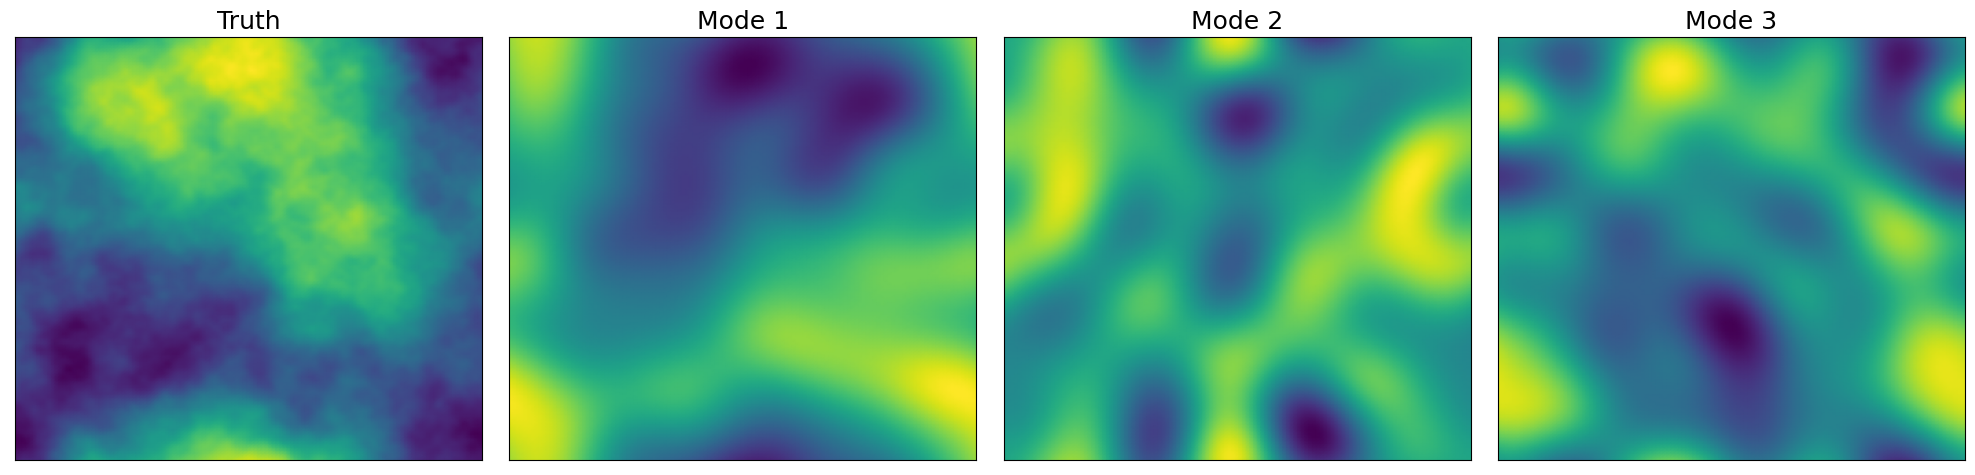

In [25]:
function plot_field(mesh::Spectral_Mesh, grid_dat::Array{Float64,2}, clim, ax; cmap="viridis")
    
    N_x, N_y = mesh.N_x, mesh.N_y
    xx, yy = mesh.xx, mesh.yy
    X,Y = repeat(xx, 1, N_y), repeat(yy, 1, N_x)'
    
    return ax.pcolormesh(X, Y, grid_dat, shading= "gouraud", clim=clim, cmap=cmap)
end


N_ens = 2N_θ + 1
# visulize the log permeability field
fig_vor, ax_vor = PyPlot.subplots(ncols = 4, sharex=true, sharey=true, figsize=(20,5))
for ax in ax_vor ;  ax.set_xticks([]) ; ax.set_yticks([]) ; end
color_lim = (minimum(s_param.ω0_ref), maximum(s_param.ω0_ref))

plot_field(mesh, s_param.ω0_ref, color_lim, ax_vor[1]) 
ax_vor[1].set_title("Truth")

grid_vor = Initial_ω0_KL(mesh, ukiobj.θ_mean[N_iter][1,:], s_param.seq_pairs)   
plot_field(mesh, grid_vor,  color_lim, ax_vor[2]) 
ax_vor[2].set_title("Mode 1")

grid_vor = Initial_ω0_KL(mesh, ukiobj.θ_mean[N_iter][2,:], s_param.seq_pairs)   
plot_field(mesh, grid_vor,  color_lim, ax_vor[3]) 
ax_vor[3].set_title("Mode 2")

grid_vor = Initial_ω0_KL(mesh, ukiobj.θ_mean[N_iter][3,:], s_param.seq_pairs)   
plot_field(mesh, grid_vor,  color_lim, ax_vor[4]) 
ax_vor[4].set_title("Mode 3")


fig_vor.tight_layout()
fig_vor.savefig("NS-2D-vor.pdf")







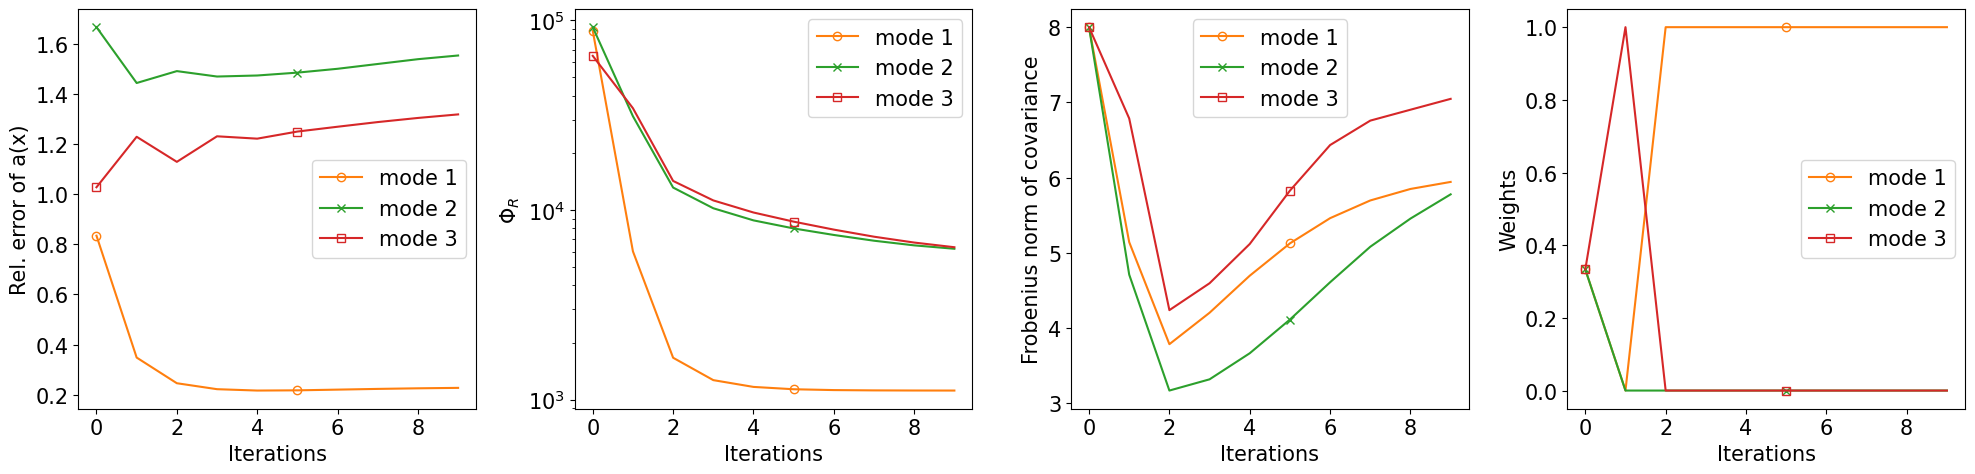

In [27]:
N_ens = 2N_θ + 1
fig, (ax1, ax2, ax3, ax4) = PyPlot.subplots(ncols=4, figsize=(20,5))
ites = Array(LinRange(0, N_iter-1, N_iter))
errors = zeros(Float64, (3, N_iter, N_modes))

for m = 1:N_modes
    for i = 1:N_iter
        if m in [2,3]
            grid_vor_truth = s_param.ω0_ref
        else
            grid_vor_truth = -s_param.ω0_ref[[1;end:-1:2], :]
        end
        
        grid_vor = Initial_ω0_KL(mesh, ukiobj.θ_mean[i][m,:], s_param.seq_pairs)   

        errors[1, i, m] = norm(grid_vor_truth - grid_vor)/norm(grid_vor_truth)
        errors[2, i, m] = 0.5*(ukiobj.y_pred[i][m,:] - ukiobj.y)'*(ukiobj.Σ_η\(ukiobj.y_pred[i][m,:] - ukiobj.y))
        errors[3, i, m] = norm(ukiobj.θθ_cov[i][m,:,:])
    end
end

linestyles = ["o"; "x"; "s"]
markevery = 5
for m = 1: N_modes
    ax1.plot(ites, errors[1, :, m], marker=linestyles[m], color = "C"*string(m), fillstyle="none", markevery=markevery, label= "mode "*string(m))
end
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Rel. error of a(x)")
ax1.legend()

for m = 1: N_modes
    ax2.semilogy(ites, errors[2, :, m], marker=linestyles[m], color = "C"*string(m), fillstyle="none", markevery=markevery, label= "mode "*string(m))
end
ax2.set_xlabel("Iterations")
ax2.set_ylabel(L"\Phi_R")
ax2.legend()

for m = 1: N_modes
    ax3.plot(ites, errors[3, :, m], marker=linestyles[m], color = "C"*string(m), fillstyle="none", markevery=markevery, label= "mode "*string(m))
end
ax3.set_xlabel("Iterations")
ax3.set_ylabel("Frobenius norm of covariance")
ax3.legend()


θ_w = exp.(hcat(ukiobj.logθ_w...))
for m = 1: N_modes
    ax4.plot(ites, θ_w[m, 1:N_iter], marker=linestyles[m], color = "C"*string(m), fillstyle="none", markevery=markevery, label= "mode "*string(m))
end
ax4.set_xlabel("Iterations")
ax4.set_ylabel("Weights")
ax4.legend()
fig.tight_layout()
fig.savefig("NS-2D-convergence.pdf")




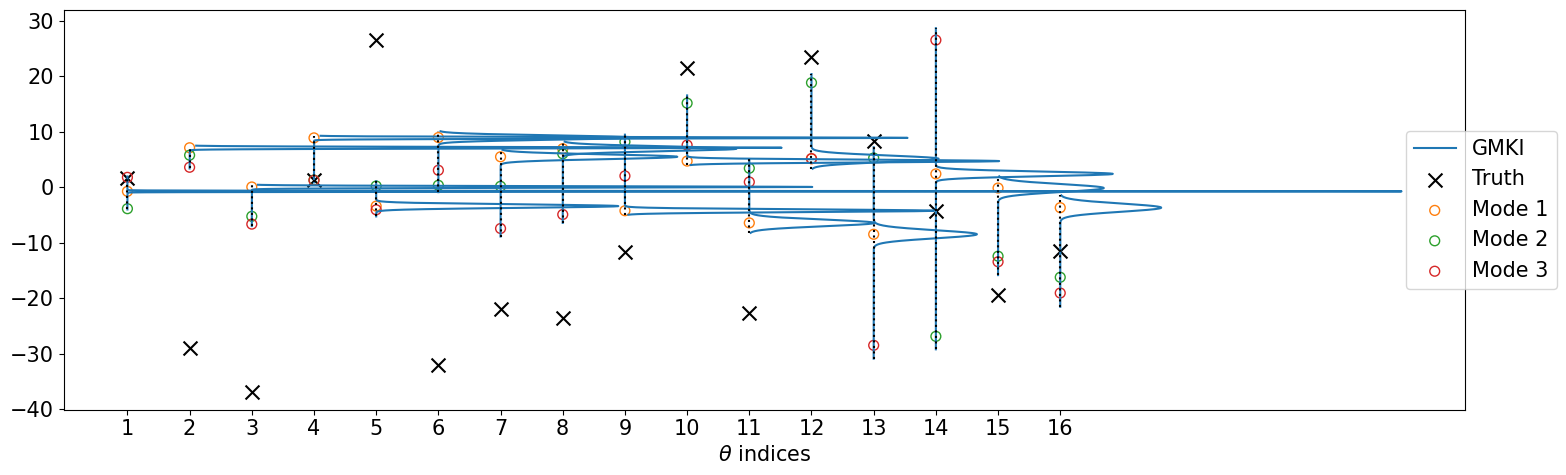

In [28]:
fig, ax = PyPlot.subplots(ncols=1, figsize=(16,5))
θ_ref = s_param.θ_ref

n_ind = 16
θ_ind = Array(1:n_ind)
ax.scatter(θ_ind, θ_ref[θ_ind], s = 100, marker="x", color="black", label="Truth")
for m = 1:N_modes
    ax.scatter(θ_ind, ukiobj.θ_mean[N_iter][m,θ_ind], s = 50, marker="o", color="C"*string(m), facecolors="none", label="Mode "*string(m))
end

Nx = 1000
for i in θ_ind
    θ_min = minimum(ukiobj.θ_mean[N_iter][:,i] .- 3sqrt.(ukiobj.θθ_cov[N_iter][:,i,i]))
    θ_max = maximum(ukiobj.θ_mean[N_iter][:,i] .+ 3sqrt.(ukiobj.θθ_cov[N_iter][:,i,i]))
        
    xxs = zeros(N_modes, Nx)  
    zzs = zeros(N_modes, Nx)  
    for m =1:N_modes
        xxs[m, :], zzs[m, :] = Gaussian_1d(ukiobj.θ_mean[N_iter][m,i], ukiobj.θθ_cov[N_iter][m,i,i], Nx, θ_min, θ_max)
        zzs[m, :] *= exp(ukiobj.logθ_w[N_iter][m]) * 3
    end
    label = nothing
    if i == 1
        label = "GMKI"
    end
    ax.plot(sum(zzs, dims=1)' .+ i, xxs[1,:], linestyle="-", color="C0", fillstyle="none", label=label)
    ax.plot(fill(i, Nx), xxs[1,:], linestyle=":", color="black", fillstyle="none")
        
end
ax.set_xticks(θ_ind)
ax.set_xlabel(L"\theta" * " indices")
ax.legend(loc="center left", bbox_to_anchor=(0.95, 0.5))
fig.tight_layout()
fig.savefig("NS-2D-density.pdf")



64-element Vector{Float64}:
   1.716506762300523
 -28.88342449796434
 -36.7786908638974
   1.2786606582308078
  26.488804192493735
 -32.04865334612308
 -21.873280347440733
 -23.462495252360355
 -11.593931827773151
  21.543950446421753
 -22.56203955900574
  23.480608984183903
   8.330448369990366
   ⋮
  -1.7951984725849293
  44.760328710647975
  10.795226516468448
   6.952920400175996
  14.559762999428692
  -7.095645852496612
 -17.24033779934284
 -28.13346489924168
   1.8603369239483232
   7.568389439555078
 -19.79584253286886
 -20.376927871657458

In [39]:
4.442882938158405 / (pi)

1.4142135623731076